In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(12, 12)


import geopandas as gpd
import pandas as pd
import rasterio as rio

from rasterio import plot as rio_plot

# HRSL Uganda

**Note: This data is all compressed on S3 so you will need to unzip both the GADM data (shapefiles of political boundaries) and the HRSL data (raster grids of population) before running this notebook.**

 - Load Admin2 boundaries from GADM
 - Select Rawanda as a test case
 - plot the boundaries
 - plot all the data
 - Calculate the sum per admin area using `zonal_stats`
 - plot the calculated populations
 

### Load GADM boundaries

In [2]:
boundaries = gpd.read_file(str(Path('../data/external/gadm28_levels.shp/gadm28_adm2.shp')))

In [3]:
admin_2 = boundaries[boundaries.ISO == 'UGA']

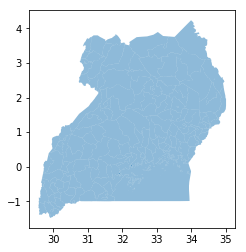

In [4]:
admin_2.plot(alpha=0.5)

### Load HRSL data

In [5]:
hrsl_path = str(Path("../data/external/HRSL/uga/hrsl_uga.tif"))
rst = rio.open(hrsl_path)

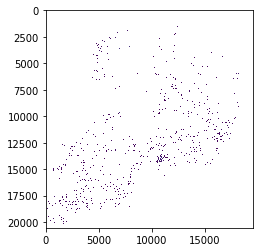

In [6]:
rio_plot.show(rst, cmap=plt.cm.viridis)

### Calculate sum of population for each admin area

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is try

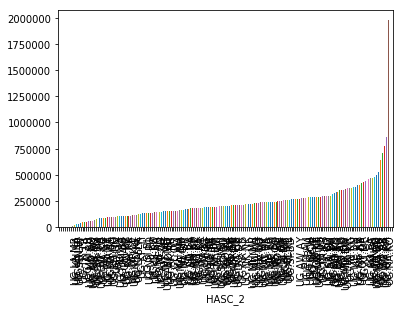

In [7]:
import rasterstats as rs

pop_list = rs.zonal_stats(admin_2, hrsl_path, stats='sum')
admin_2['hrsl_pop'] = [x['sum'] for x in pop_list]

(admin_2.set_index('HASC_2')
        .hrsl_pop
        .sort_values()
        .plot(kind='bar'))

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


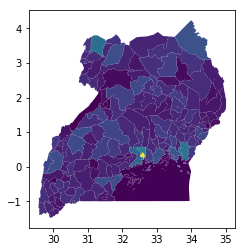

In [8]:
admin_2.plot(column='hrsl_pop')

# Load World Pop Births

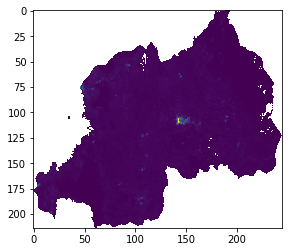

In [9]:
worldpop_births_path = str(Path("../data/external/WorldPop/Rwanda 1km births/RWA_births_pp_v2_2015.tif"))

rst = rio.open(worldpop_births_path)
rio_plot.show(rst, cmap=plt.cm.viridis)

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is try

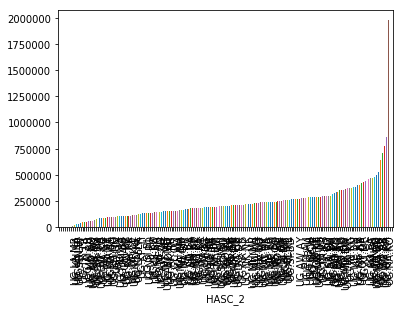

In [10]:
pop_list = rs.zonal_stats(admin_2, worldpop_births_path, stats='sum')
admin_2['worldpop_births'] = [x['sum'] for x in pop_list]

(admin_2.set_index('HASC_2')
            .hrsl_pop
            .sort_values()
            .plot(kind='bar'))

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


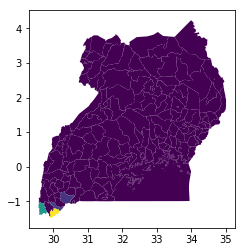

In [11]:
admin_2.plot(column='worldpop_births')

### Load WHO data

In [16]:
who_df = pd.read_csv(Path("../data/interim/calc_cols_added.csv"), index_col=0)

who_df = who_df[who_df['Iso Code'] == 'UGA']
who_df.head(2)

,Iso Code,Country Name,WHO Region,Year,Vaccine Type,Admin1,Admin2,DenomType,Denominator,Numerator,Coverage,recalc_numerator,available_admin,normalized_country,indicator,group,vaccine,timing
126103,UGA,Uganda,AFRO,2016,HepB_BD,Abim,Abim,1.0,5895.0,NaN,NaN,NaN,Abim - Abim,uganda,1,HepB,HepB_BD,1st_birth
126104,UGA,Uganda,AFRO,2016,BCG,Abim,Abim,1.0,5895.0,NaN,89.860836,5297.296285,Abim - Abim,uganda,1,BCG,BCG,1st_birth


### Estimate population with WHO data

 - Get denominator for each region
 - Multiply by the crude birth rate (https://data.worldbank.org/indicator/SP.DYN.CBRT.IN)
 - Remove " Distrct" from names
 - Plot estimates

In [17]:
who_births = (who_df[who_df.DenomType == 1]
                         .groupby('Admin2')
                         .Denominator
                         .first())

who_pops = who_births.multiply(1000 / 32)  # crude birth rate for rwanda

# index to names that will match admin2
# # who_births.index = who_births.index.str.strip(" District")
who_births.name = 'who_reported_births'

# who_rwa_pops.index = who_rwa_pops.index.str.strip(" District")
who_pops.name = 'who_pop_estimate'

who_pops

Admin2
Abim              184218.75
Adjumani          347562.50
Agago             357781.25
Alebtong          364437.50
Amolatar          239406.25
Amudat            174375.00
Amuria            439031.25
Amuru             298437.50
Apac              596187.50
Arua             1252656.25
Budaka            337062.50
Bududa            347843.75
Bugiri            615687.50
Buhweju           194500.00
Buikwe            667968.75
Bukedea           335687.50
Bukomansimbi      232718.75
Bukwo             149312.50
Bulambuli         291031.25
Buliisa           188375.00
Bundibugyo        360093.75
Bushenyi          363187.50
Busia             520437.50
Butaleja          397937.50
Butambala         156843.75
Buvuma            153937.50
Buyende           533687.50
Dokolo            293843.75
Gomba             249718.75
Gulu              704343.75
                    ...    
Mpigi             398187.50
Mubende          1121843.75
Mukono            957750.00
Nakapiripirit     259843.75
Nakaseke     

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


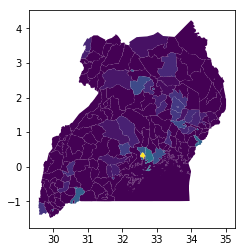

In [19]:
(admin_2.set_index('NAME_2')
            .join(who_pops)
            .plot(column='who_pop_estimate'))

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


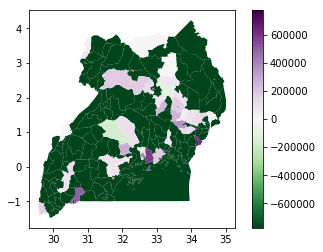

In [20]:
diff_data = (admin_2.set_index('NAME_2')
                        .join(who_pops)
                        .assign(who_diff=lambda x: x.who_pop_estimate - x.hrsl_pop))


diff_data.plot(column='who_diff',
               cmap=plt.cm.PRGn_r,
               legend=True,
               vmin=-diff_data.who_diff.abs().max(),
               vmax=diff_data.who_diff.abs().max())

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


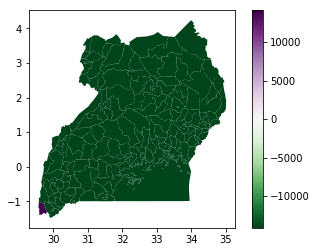

In [21]:
diff_data2 = (admin_2.set_index('NAME_2')
                        .join(who_births)
                        .assign(worldpop_diff=lambda x: x.who_reported_births - x.worldpop_births))


diff_data2.plot(column='worldpop_diff',
               cmap=plt.cm.PRGn_r,
               legend=True,
               vmin=-diff_data2.worldpop_diff.abs().max(),
               vmax=diff_data2.worldpop_diff.abs().max())
